In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = os.path.join('.', 'drive/MyDrive/inz/data_dl')

batch_size = 32
img_size = 150
random_state = 44

tf.keras.utils.set_random_seed(random_state)

In [4]:
def loadAndDivideIntoCategories(datasetPath, newImgSize):
  images, labels = list(), list()

  categories = os.listdir(datasetPath)
  for category in categories:
    categoryPath = datasetPath + "/" + category

    for imageName in os.listdir(categoryPath):
      if 'benign' in os.path.basename(os.path.normpath(categoryPath)):
          labels.append(0)
      elif 'malign' in os.path.basename(os.path.normpath(categoryPath)):
          labels.append(1)
      imagePath = categoryPath + "/" + imageName
      images.append(cv2.resize(cv2.imread(imagePath), (newImgSize, newImgSize), interpolation=cv2.INTER_CUBIC))       
  return images, labels

In [5]:
X, y = loadAndDivideIntoCategories(data_path, img_size)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

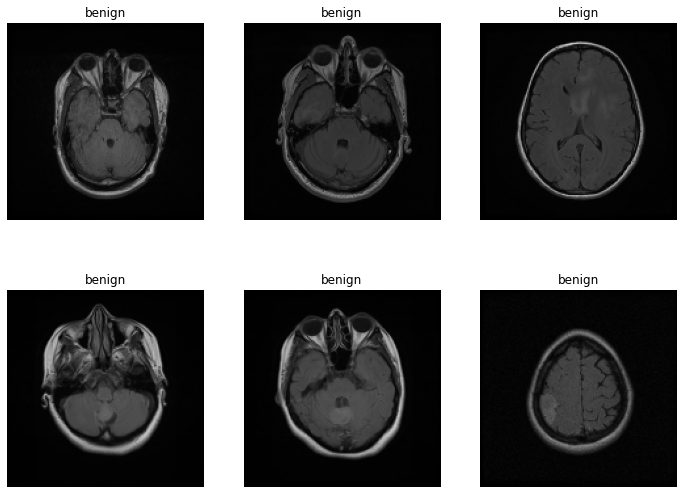

In [7]:
import random
labels = {0: 'benign', 1: 'malign'}

rows = 2
cols = 3

fig, axs = plt.subplots(rows, cols, figsize=(12,9))
 
for i in range(rows):
  for j in range(cols):
    idx = random.randint(0, len(X_train)-1)
    img, label = X_train[idx], y_train[idx]

    axs[i][j].axis('off')
    axs[i][j].imshow(img)
    axs[i][j].set_title(labels[np.argmax(label)])

# Augmentacja danych

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IDG = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

train_generator = IDG.flow(np.array(X_train), y_train, batch_size=batch_size)
val_generator = IDG.flow(np.array(X_val), y_val, batch_size=batch_size)

In [9]:
base_model = tf.keras.applications.EfficientNetV2M(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')

214201816/214201816 [==============================] - 7s 0us/step


In [10]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 24)   96          ['stem_conv[0][0]'

In [11]:
inputs = base_model.input
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

In [13]:
len(model.trainable_variables)

2

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 24)   96          ['stem_conv[0][0]']          

In [15]:
initial_epochs = 10

loss0, accuracy0, precision, recall, AUC = model.evaluate(train_generator)

print("startowa funkcja straty: {:.2f}".format(loss0))
print("Początkowa dokładność: {:.2f}".format(accuracy0))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 21s 212ms/step - loss: 0.8569 - binary_accuracy: 0.3185 - precision: 0.3114 - recall: 0.9914 - auc: 0.4978
startowa funkcja straty: 0.86
Początkowa dokładność: 0.32


In [16]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator)

Epoch 1/10
36/36 [==============================] - 27s 249ms/step - loss: 0.6510 - binary_accuracy: 0.6254 - precision: 0.3048 - recall: 0.1638 - auc: 0.5325 - val_loss: 0.6077 - val_binary_accuracy: 0.6929 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6082
Epoch 2/10
36/36 [==============================] - 8s 225ms/step - loss: 0.6177 - binary_accuracy: 0.6735 - precision: 0.2979 - recall: 0.0402 - auc: 0.5668 - val_loss: 0.5922 - val_binary_accuracy: 0.7071 - val_precision: 1.0000 - val_recall: 0.0465 - val_auc: 0.6310
Epoch 3/10
36/36 [==============================] - 8s 226ms/step - loss: 0.6056 - binary_accuracy: 0.6931 - precision: 0.5789 - recall: 0.0316 - auc: 0.5945 - val_loss: 0.5832 - val_binary_accuracy: 0.7214 - val_precision: 1.0000 - val_recall: 0.0930 - val_auc: 0.6544
Epoch 4/10
36/36 [==============================] - 8s 225ms/step - loss: 0.5949 - binary_accuracy: 0.7046 - precision: 0.6250 - recall: 0.1149 - auc: 0.6344 - val_loss: 0.5980 - va

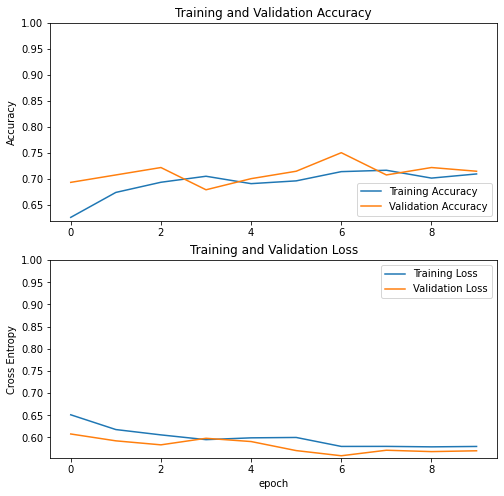

In [17]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Dostrajanie 

In [18]:
base_model.trainable = True

In [19]:
print("Liczba warstw w modelu bazowym: ", len(base_model.layers))

fine_tune_at = 640

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Liczba warstw w modelu bazowym:  740


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 24)   96          ['stem_conv[0][0]']          

In [22]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator)

Epoch 10/30
36/36 [==============================] - 37s 403ms/step - loss: 0.6580 - binary_accuracy: 0.6664 - precision_1: 0.4192 - recall_1: 0.2011 - auc_1: 0.5918 - val_loss: 0.8063 - val_binary_accuracy: 0.6071 - val_precision_1: 0.4000 - val_recall_1: 0.5581 - val_auc_1: 0.6328
Epoch 11/30
36/36 [==============================] - 9s 241ms/step - loss: 0.5894 - binary_accuracy: 0.7117 - precision_1: 0.5833 - recall_1: 0.2414 - auc_1: 0.6642 - val_loss: 0.5813 - val_binary_accuracy: 0.7214 - val_precision_1: 0.5769 - val_recall_1: 0.3488 - val_auc_1: 0.7444
Epoch 12/30
36/36 [==============================] - 9s 242ms/step - loss: 0.5518 - binary_accuracy: 0.7251 - precision_1: 0.6154 - recall_1: 0.2989 - auc_1: 0.7095 - val_loss: 0.6224 - val_binary_accuracy: 0.7429 - val_precision_1: 0.6061 - val_recall_1: 0.4651 - val_auc_1: 0.7478
Epoch 13/30
36/36 [==============================] - 9s 242ms/step - loss: 0.5156 - binary_accuracy: 0.7802 - precision_1: 0.7760 - recall_1: 0.4080 -

In [45]:
!pip install pyyaml h5py
model.save("drive/MyDrive/modelEfficientNetV2M.h5")
print("Saved model to disk")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Saved model to disk


In [26]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

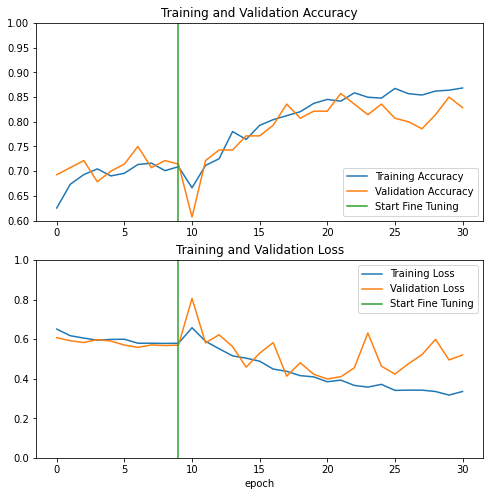

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### VALIDATION DATASET EVALUATION

In [68]:
def predict_proba_for_all(X, model):
    y_pred_proba = []
    for x in X:
        y_pred_proba.append(model.predict(np.array([x]), verbose=0).squeeze())

    return y_pred_proba

y_pred_proba = predict_proba_for_all(X_val, model)

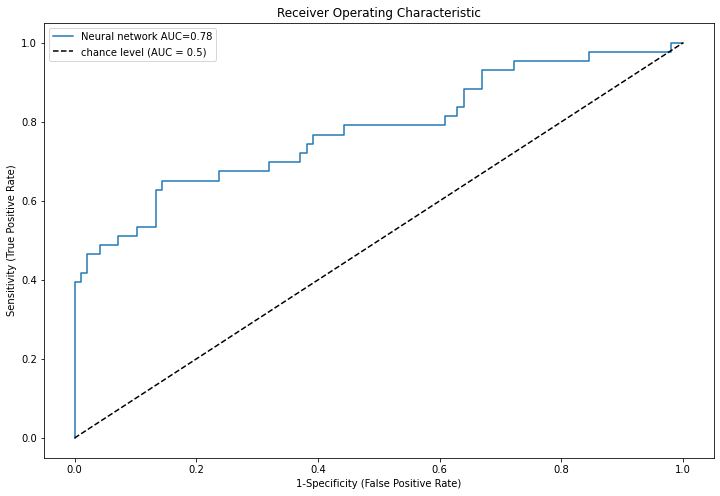

In [69]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label=f"Neural network AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

best_f1 = 0
best_th = None
thresholds_lst = list(thresholds)
thresholds_lst.append(0.5)

y_pred_proba = np.array(y_pred_proba)
for threshold in thresholds_lst:
    y_pred = y_pred_proba > threshold
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_th = threshold

In [71]:
import pandas as pd
name = "EfficientNetV2M"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}

y_pred = y_pred_proba > 0.5
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_val, y_pred))
results['F1 score'].append(f1_score(y_val, y_pred))
results['Precision'].append(precision_score(y_val, y_pred))
results['Recall'].append(recall_score(y_val, y_pred))


results_df = pd.DataFrame(results)
print("Results before threshold adjustment on VALIDATION data")
results_df.head()

Results before threshold adjustment on VALIDATION data


,Name,Accuracy,F1 score,Precision,Recall
0,EfficientNetV2M,0.792857,0.60274,0.733333,0.511628


In [72]:
name = "EfficientNetV2M"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > best_th
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_val, y_pred))
results['F1 score'].append(f1_score(y_val, y_pred))
results['Precision'].append(precision_score(y_val, y_pred))
results['Recall'].append(recall_score(y_val, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION data")
results_df.head()

Results after threshold adjustment on VALIDATION data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,EfficientNetV2M,0.792857,0.650602,0.675,0.627907,0.329729


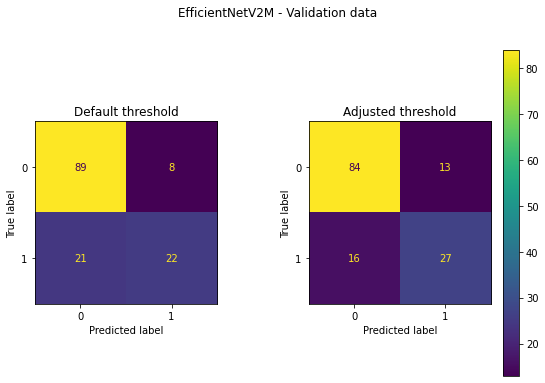

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(9,6))

y_pred = y_pred_proba > 0.5
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[0])
disp.ax_.set_title("Default threshold")
disp.im_.colorbar.remove()


y_pred = y_pred_proba > best_th
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[1])
disp.ax_.set_title("Adjusted threshold")
plt.suptitle(f"{name} - Validation data")
plt.show()

### TEST DATASET EVALUATION

In [74]:
y_pred_proba = predict_proba_for_all(X_test, model)

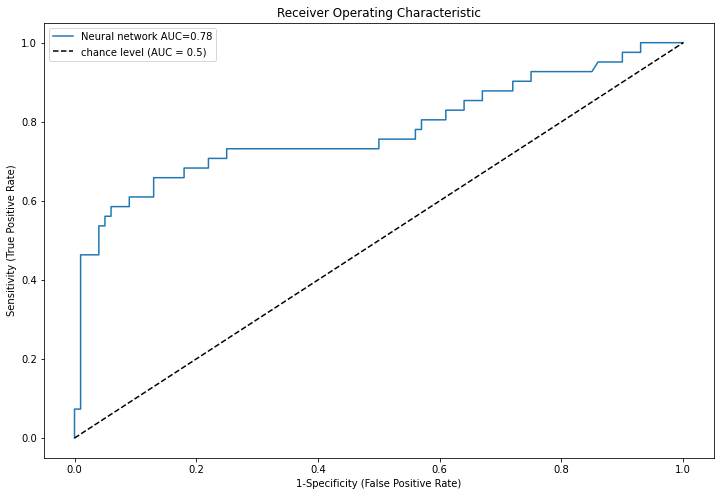

In [75]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label=f"Neural network AUC={roc_auc:.2f}"+str())
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [66]:
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# best_f1 = 0
# best_th = None
# thresholds_lst = list(thresholds)
# thresholds_lst.append(0.5)

# y_pred_proba = np.array(y_pred_proba)
# for threshold in thresholds_lst:
#     y_pred = y_pred_proba > threshold
#     f1 = f1_score(y_test, y_pred)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_th = threshold

In [77]:
import pandas as pd
name = "EfficientNetV2M"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
y_pred_proba = np.array(y_pred_proba)
y_pred = y_pred_proba > 0.5
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_test, y_pred))
results['F1 score'].append(f1_score(y_test, y_pred))
results['Precision'].append(precision_score(y_test, y_pred))
results['Recall'].append(recall_score(y_test, y_pred))


results_df = pd.DataFrame(results)
print("Results before threshold adjustment on TEST data")
results_df.head()

Results before threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall
0,EfficientNetV2M,0.822695,0.657534,0.75,0.585366


In [78]:
name = "EfficientNetV2M"
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

y_pred = y_pred_proba > best_th
results['Name'].append(name)
results['Accuracy'].append(accuracy_score(y_test, y_pred))
results['F1 score'].append(f1_score(y_test, y_pred))
results['Precision'].append(precision_score(y_test, y_pred))
results['Recall'].append(recall_score(y_test, y_pred))
results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head()

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,EfficientNetV2M,0.787234,0.642857,0.627907,0.658537,0.329729


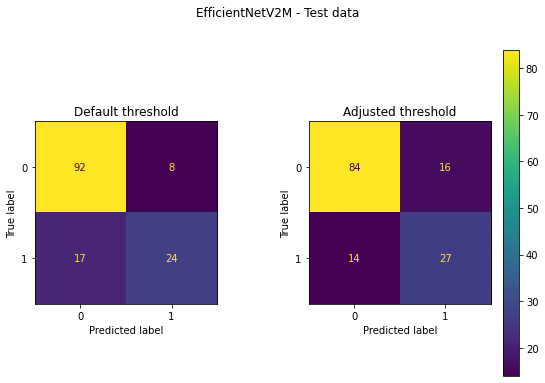

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(9,6))

y_pred = y_pred_proba > 0.5
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[0])
disp.ax_.set_title("Default threshold")
disp.im_.colorbar.remove()


y_pred = y_pred_proba > best_th
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[1])
disp.ax_.set_title("Adjusted threshold")
plt.suptitle(f"{name} - Test data")
plt.show()